# Tree-based classifier

Include all possible dimensions and train a treebased classifier

In [2]:
import pandas as pd

In [52]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import metrics
from sklearn import utils
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_log_error,mean_squared_error

In [11]:
import numpy as np

In [13]:
import matplotlib.pyplot as plt

In [10]:
import seaborn as sns

## Load Data

In [4]:
df = pd.read_csv('/Users/leima/data_store/rideindego_all.csv')

/Users/leima/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0,3,4,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df['date'] = pd.to_datetime(df.date)

In [6]:
df.head()

,bike_id,bike_type,duration,end_lat,end_lon,end_station_id,end_time,passholder_type,plan_duration,start_lat,start_lon,start_station_id,start_time,trip_id,trip_route_category,date,hour,weekday,month
0,3640,standard,4.0,39.9384,-75.173271,3064,7/1/2016 0:11,Indego30,30,39.946331,-75.1698,3063.0,7/1/2016 0:07,25183529,One Way,2016-07-01,0,4,7
1,3349,standard,8.0,39.94138,-75.145638,3026,7/1/2016 0:18,Indego30,30,39.95295,-75.139793,3124.0,7/1/2016 0:10,25183528,One Way,2016-07-01,0,4,7
2,5279,standard,17.0,39.933151,-75.162483,3034,7/1/2016 0:28,Indego30,30,39.93082,-75.174744,3043.0,7/1/2016 0:11,25183527,One Way,2016-07-01,0,4,7
3,5198,standard,25.0,39.94138,-75.145638,3026,7/1/2016 0:38,Walk-up,0,39.94138,-75.145638,3026.0,7/1/2016 0:13,25183526,Round Trip,2016-07-01,0,4,7
4,3382,standard,45.0,39.947109,-75.166183,3010,7/1/2016 0:58,Walk-up,0,39.954239,-75.161377,3037.0,7/1/2016 0:13,25183525,One Way,2016-07-01,0,4,7


In [7]:
df = df[df.bike_type == 'standard']
coi = [
    'passholder_type', 
    'trip_route_category', 'hour', 'weekday', 'month'
]
cot = ['duration']
df = df[coi+cot]

In [8]:
df.head()

,passholder_type,trip_route_category,hour,weekday,month,duration
0,Indego30,One Way,0,4,7,4.0
1,Indego30,One Way,0,4,7,8.0
2,Indego30,One Way,0,4,7,17.0
3,Walk-up,Round Trip,0,4,7,25.0
4,Walk-up,One Way,0,4,7,45.0


Check correlations

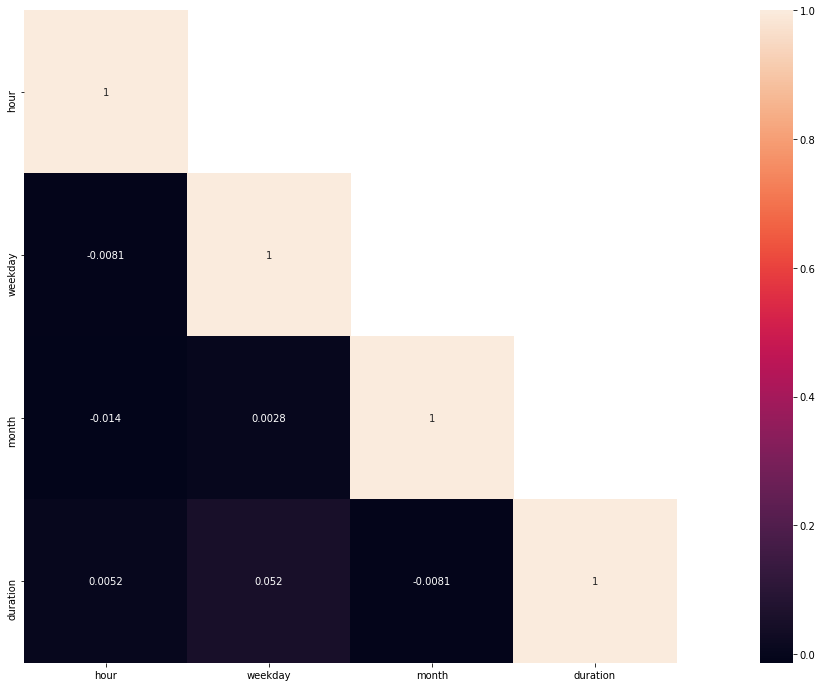

In [15]:
cor_mat = df.corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

In [16]:
for i in df.columns:
    print(
        i, ': ',
        df[i].isnull().any()
    )

passholder_type :  False
trip_route_category :  False
hour :  False
weekday :  False
month :  False
duration :  False


In [17]:
scaler = StandardScaler()

In [62]:
X = df[coi]
#X = pd.get_dummies(X)
y = df[cot]
y = scaler.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3, random_state=42
    #,stratify=Y
)

In [63]:
class MultiColumnLabelEncoder:
    def __init__(self, encoders = None, columns = None):
        self.columns = columns # array of column names to encode
        if encoders:
            self.encoders = encoders
        else:
            self.encoders = {}

    def fit(self,X,y=None):
        self.check_encoders = []
        return self # not relevant here

    def transform(self, X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                _le = LabelEncoder()
                if self.encoders.get(col):
                    output[col] = self.encoders.get(col).transform(output[col])
                else:
                    output[col] = _le.fit_transform(output[col])
                    print(f'1. preparing encoder for {col}')
                    self.encoders[col] = _le
                    self.check_encoders.append({col: _le})
        else:
            for colname,col in output.iteritems():
                _le = LabelEncoder()
                if self.encoders.get(col):
                    output[colname] = self.encoders.get(col).transform(col)
                else:
                    output[colname] = _le.fit_transform(col)
                    print(f'2. preparing encoder for {col}')
                    self.encoders[col] = _le
                    self.check_encoders.append({col: _le})
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [64]:
encoders_obj = MultiColumnLabelEncoder(columns=coi)
encoders_obj.fit_transform(df)
dt_encoders = encoders_obj.encoders

1. preparing encoder for passholder_type
1. preparing encoder for trip_route_category
1. preparing encoder for hour
1. preparing encoder for weekday
1. preparing encoder for month


In [65]:
coi

['passholder_type', 'trip_route_category', 'hour', 'weekday', 'month']

In [69]:
bootstrap_number = [500]

random_forest_classifier = GridSearchCV(
    RandomForestRegressor(), cv=3, 
    param_grid={'n_estimators':bootstrap_number, 'n_jobs':[-1], 'max_features': ["auto",'sqrt','log2'] }
)

random_forest_pipeline_steps = [
    ('encoding', MultiColumnLabelEncoder(columns=coi, encoders=dt_encoders)),
    ('dt_classifier', random_forest_classifier)
    # add more pipeline steps as needed
]

In [70]:
model_random_forest = Pipeline(random_forest_pipeline_steps)

In [ ]:
model_random_forest.fit(X_train[:10000], y_train[:10000])

In [93]:
model_random_forest_pred = model_random_forest.predict(X_test[:1000])
print((np.sqrt(mean_squared_error(model_random_forest_pred,y_test[:1000]))))

1.0644042393602757


In [94]:
model_random_forest.score(X_test[:1000], y_test[:1000])

-0.11448162682867391

In [78]:
n_neighbors = [
    5,10,15,20,25,30,35,40,45,50
]

knn_regressor = GridSearchCV(
    KNeighborsRegressor(), cv=3, 
    param_grid={'n_neighbors':n_neighbors,'n_jobs':[-1]}
)

knn_regressor_pipeline_steps = [
    ('encoding', MultiColumnLabelEncoder(columns=coi, encoders=dt_encoders)),
    ('knn_regressor', knn_regressor)
    # add more pipeline steps as needed
]

In [79]:
model_knn_regressor = Pipeline(knn_regressor_pipeline_steps)

In [86]:
model_knn_regressor.fit(X_train[:200000], y_train[:200000])

Pipeline(memory=None,
     steps=[('encoding', <__main__.MultiColumnLabelEncoder object at 0x1a2fec8c50>), ('knn_regressor', GridSearchCV(cv=3, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          wei...   pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0))])

In [96]:
model_knn_regressor.score(X_test[:100000], y_test[:100000])

0.015938676017181908

In [97]:
model_knn_regressor_pred = model_knn_regressor.predict(X_test[:10000])
print((np.sqrt(mean_squared_error(model_knn_regressor_pred,y_test[:10000]))))

1.047346857624649
